# Chapter 4: Relationship Analysis

**Purpose:** Explore feature correlations, relationships with the target, and identify predictive signals.

**What you'll learn:**
- How to interpret correlation matrices and identify multicollinearity
- How to visualize feature distributions by target class
- How to identify which features have the strongest relationship with retention
- How to analyze categorical features for predictive power

**Outputs:**
- Correlation heatmap with multicollinearity detection
- Feature distributions by retention status (box plots)
- Retention rates by categorical features
- Feature-target correlation rankings

---

## Understanding Feature Relationships

| Analysis | What It Tells You | Action |
|----------|------------------|--------|
| **High Correlation** (r > 0.7) | Features carry redundant information | Consider removing one |
| **Target Correlation** | Feature's predictive power | Prioritize high-correlation features |
| **Class Separation** | How different retained vs churned look | Good separation = good predictor |
| **Categorical Rates** | Retention varies by category | Use for segmentation and encoding |

## 4.1 Setup

In [1]:
from customer_retention.analysis.auto_explorer import ExplorationFindings, RecommendationRegistry
from customer_retention.analysis.visualization import ChartBuilder, display_figure, display_table
from customer_retention.core.config.column_config import ColumnType
from customer_retention.stages.profiling import (
    RelationshipRecommender, RecommendationCategory
)
import yaml
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from customer_retention.core.config.experiments import FINDINGS_DIR, EXPERIMENTS_DIR, OUTPUT_DIR, setup_experiments_structure


In [2]:
# === CONFIGURATION ===
# Option 1: Set the exact path from notebook 01 output
# FINDINGS_PATH = "../experiments/findings/customer_retention_retail_abc123_findings.yaml"

# Option 2: Auto-discover the most recent findings file
from pathlib import Path

# FINDINGS_DIR imported from customer_retention.core.config.experiments

findings_files = [f for f in FINDINGS_DIR.glob("*_findings.yaml") if "multi_dataset" not in f.name]
if not findings_files:
    raise FileNotFoundError(f"No findings files found in {FINDINGS_DIR}. Run notebook 01 first.")

# Prefer aggregated findings (from 01d) over event-level findings
# Pattern: *_aggregated* in filename indicates aggregated data
aggregated_files = [f for f in findings_files if "_aggregated" in f.name]
non_aggregated_files = [f for f in findings_files if "_aggregated" not in f.name]

if aggregated_files:
    # Use most recent aggregated file
    aggregated_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    FINDINGS_PATH = str(aggregated_files[0])
    print(f"Found {len(aggregated_files)} aggregated findings file(s)")
    print(f"Using: {FINDINGS_PATH}")
    if non_aggregated_files:
        print(f"   (Skipping {len(non_aggregated_files)} event-level findings)")
else:
    # Fall back to most recent non-aggregated file
    non_aggregated_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    FINDINGS_PATH = str(non_aggregated_files[0])
    print(f"Found {len(findings_files)} findings file(s)")
    print(f"Using: {FINDINGS_PATH}")

RECOMMENDATIONS_PATH = FINDINGS_PATH.replace("_findings.yaml", "_recommendations.yaml")

findings = ExplorationFindings.load(FINDINGS_PATH)

# Load data - handle aggregated vs standard paths
from customer_retention.stages.temporal import load_data_with_snapshot_preference, TEMPORAL_METADATA_COLS

# For aggregated data, load directly from the parquet source
if "_aggregated" in FINDINGS_PATH and findings.source_path.endswith('.parquet'):
    source_path = Path(findings.source_path)
    # Handle relative path from notebook directory
    if not source_path.is_absolute():
        # The source_path in findings is relative to project root
        if str(source_path).startswith("experiments"):
            source_path = Path("..") / source_path
        else:
            source_path = FINDINGS_DIR / source_path.name
    df = pd.read_parquet(source_path)
    data_source = f"aggregated:{source_path.name}"
else:
    # Standard loading for event-level or entity-level data
    df, data_source = load_data_with_snapshot_preference(findings, output_dir=str(FINDINGS_DIR))

charts = ChartBuilder()

if Path(RECOMMENDATIONS_PATH).exists():
    with open(RECOMMENDATIONS_PATH, "r") as f:
        registry = RecommendationRegistry.from_dict(yaml.safe_load(f))
    print(f"Loaded existing recommendations: {len(registry.all_recommendations)} total")
else:
    registry = RecommendationRegistry()
    registry.init_bronze(findings.source_path)
    registry.init_silver(findings.entity_column or "entity_id")
    registry.init_gold(findings.target_column or "target")
    print("Initialized new recommendation registry")

print(f"\nLoaded {len(df):,} rows from: {data_source}")

Found 1 aggregated findings file(s)
Using: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_findings.yaml
   (Skipping 1 event-level findings)


Loaded existing recommendations: 104 total

Loaded 4,998 rows from: aggregated:customer_emails_408768_aggregated.parquet


## 4.2 Numeric Correlation Matrix

**📖 How to Read the Heatmap:**
- **Red (+1)**: Perfect positive correlation - features move together
- **Blue (-1)**: Perfect negative correlation - features move opposite
- **White (0)**: No linear relationship

**⚠️ Multicollinearity Warning:**
- Pairs with |r| > 0.7 may cause issues in linear models
- Consider removing one feature from highly correlated pairs
- Tree-based models are more robust to multicollinearity

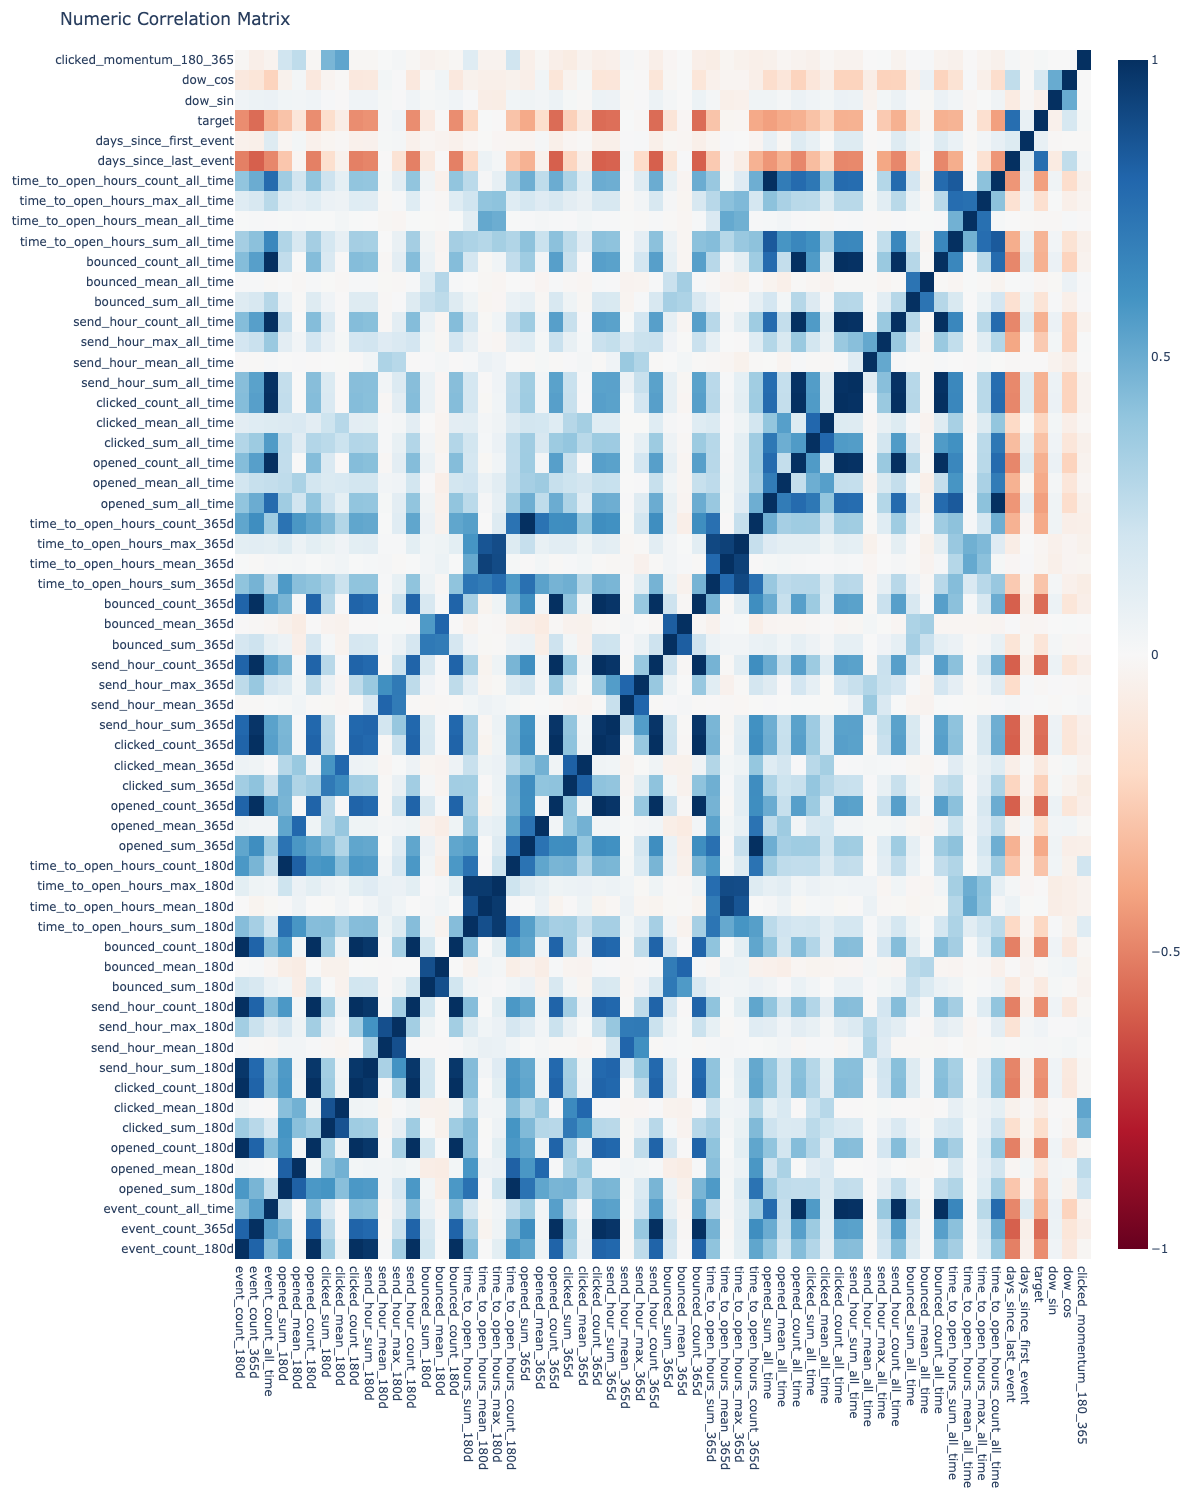

In [3]:
numeric_cols = [
    name for name, col in findings.columns.items()
    if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE, ColumnType.TARGET]
    and name not in TEMPORAL_METADATA_COLS
]

if len(numeric_cols) >= 2:
    corr_matrix = df[numeric_cols].corr()
    fig = charts.heatmap(
        corr_matrix.values,
        x_labels=numeric_cols,
        y_labels=numeric_cols,
        title="Numeric Correlation Matrix"
    )
    display_figure(fig)
else:
    print("Not enough numeric columns for correlation analysis.")

## 4.3 High Correlation Pairs

In [4]:
high_corr_threshold = 0.7
high_corr_pairs = []

if len(numeric_cols) >= 2:
    corr_matrix = df[numeric_cols].corr()
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) >= high_corr_threshold:
                high_corr_pairs.append({
                    "Column 1": numeric_cols[i],
                    "Column 2": numeric_cols[j],
                    "Correlation": f"{corr_val:.3f}"
                })

if high_corr_pairs:
    print(f"High Correlation Pairs (|r| >= {high_corr_threshold}):")
    display(pd.DataFrame(high_corr_pairs))
    print("\nConsider removing one of each pair to reduce multicollinearity.")
else:
    print("No high correlation pairs detected.")

High Correlation Pairs (|r| >= 0.7):

,Column 1,Column 2,Correlation
0,event_count_180d,event_count_365d,0.807
1,event_count_180d,opened_count_180d,1.000
2,event_count_180d,clicked_count_180d,1.000
3,event_count_180d,send_hour_sum_180d,0.975
4,event_count_180d,send_hour_count_180d,1.000
...,...,...,...
142,bounced_count_all_time,time_to_open_hours_count_all_time,0.778
143,time_to_open_hours_sum_all_time,time_to_open_hours_max_all_time,0.769
144,time_to_open_hours_sum_all_time,time_to_open_hours_count_all_time,0.843
145,time_to_open_hours_mean_all_time,time_to_open_hours_max_all_time,0.757



Consider removing one of each pair to reduce multicollinearity.


## 4.4 Feature Distributions by Retention Status

**📖 How to Interpret Box Plots:**
- **Box** = Middle 50% of data (IQR)
- **Line inside box** = Median
- **Whiskers** = 1.5 × IQR from box edges
- **Points outside** = Outliers

**⚠️ What Makes a Good Predictor:**
- **Clear separation** between retained (green) and churned (red) boxes
- **Different medians** = Feature values differ between classes
- **Minimal overlap** = Easier to distinguish classes

In [5]:
# Feature Distributions by Retention Status
if findings.target_column and findings.target_column in df.columns:
    target = findings.target_column
    
    feature_cols = [
        name for name, col in findings.columns.items()
        if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
        and name != target
        and name not in TEMPORAL_METADATA_COLS
    ]
    
    if feature_cols:
        print("=" * 80)
        print(f"FEATURE DISTRIBUTIONS BY TARGET: {target}")
        print("=" * 80)
        
        # Calculate summary statistics by target
        summary_by_target = []
        for col in feature_cols:
            for target_val, label in [(0, "Churned"), (1, "Retained")]:
                subset = df[df[target] == target_val][col].dropna()
                if len(subset) > 0:
                    summary_by_target.append({
                        "Feature": col,
                        "Group": label,
                        "Count": len(subset),
                        "Mean": subset.mean(),
                        "Median": subset.median(),
                        "Std": subset.std()
                    })
        
        if summary_by_target:
            summary_df = pd.DataFrame(summary_by_target)
            
            # Display summary table
            print("\n📊 Summary Statistics by Retention Status:")
            display_summary = summary_df.pivot(index="Feature", columns="Group", values=["Mean", "Median"])
            display_summary.columns = [f"{stat} ({group})" for stat, group in display_summary.columns]
            display(display_summary.round(3))
        
        # Calculate effect size (Cohen's d) for each feature
        print("\n📈 Feature Importance Indicators (Effect Size - Cohen's d):")
        print("-" * 70)
        effect_sizes = []
        for col in feature_cols:
            churned = df[df[target] == 0][col].dropna()
            retained = df[df[target] == 1][col].dropna()
            
            if len(churned) > 0 and len(retained) > 0:
                # Cohen's d
                pooled_std = np.sqrt(((len(churned)-1)*churned.std()**2 + (len(retained)-1)*retained.std()**2) / 
                                     (len(churned) + len(retained) - 2))
                if pooled_std > 0:
                    d = (retained.mean() - churned.mean()) / pooled_std
                else:
                    d = 0
                
                # Interpret effect size
                abs_d = abs(d)
                if abs_d >= 0.8:
                    interpretation = "Large effect"
                    emoji = "🔴"
                elif abs_d >= 0.5:
                    interpretation = "Medium effect"
                    emoji = "🟡"
                elif abs_d >= 0.2:
                    interpretation = "Small effect"
                    emoji = "🟢"
                else:
                    interpretation = "Negligible"
                    emoji = "⚪"
                
                effect_sizes.append({
                    "feature": col,
                    "cohens_d": d,
                    "abs_d": abs_d,
                    "interpretation": interpretation
                })
                
                direction = "↑ Higher in retained" if d > 0 else "↓ Lower in retained"
                print(f"  {emoji} {col}: d={d:+.3f} ({interpretation}) {direction}")
        
        # Sort by effect size for identifying important features
        if effect_sizes:
            effect_df = pd.DataFrame(effect_sizes).sort_values("abs_d", ascending=False)
            important_features = effect_df[effect_df["abs_d"] >= 0.2]["feature"].tolist()
            if important_features:
                print(f"\n⭐ Features with notable effect (|d| ≥ 0.2): {', '.join(important_features)}")
        else:
            print("  No effect sizes could be calculated (insufficient data in one or both groups)")
    else:
        print("No numeric feature columns found for distribution analysis.")
else:
    print("Target column not available.")

FEATURE DISTRIBUTIONS BY TARGET: target

📊 Summary Statistics by Retention Status:


,Mean (Churned),Mean (Retained),Median (Churned),Median (Retained)
Feature,,,,
bounced_count_180d,1.096,0.101,1.000,0.000
bounced_count_365d,2.260,0.264,2.000,0.000
bounced_count_all_time,17.248,11.273,16.000,10.000
bounced_mean_180d,0.026,0.022,0.000,0.000
bounced_mean_365d,0.026,0.018,0.000,0.000
bounced_mean_all_time,0.023,0.021,0.000,0.000
bounced_sum_180d,0.028,0.003,0.000,0.000
bounced_sum_365d,0.057,0.006,0.000,0.000
bounced_sum_all_time,0.386,0.218,0.000,0.000



📈 Feature Importance Indicators (Effect Size - Cohen's d):
----------------------------------------------------------------------
  🔴 event_count_180d: d=-1.087 (Large effect) ↓ Lower in retained
  🔴 event_count_365d: d=-1.405 (Large effect) ↓ Lower in retained
  🟡 event_count_all_time: d=-0.782 (Medium effect) ↓ Lower in retained
  🟡 opened_sum_180d: d=-0.615 (Medium effect) ↓ Lower in retained
  🟡 opened_mean_180d: d=-0.554 (Medium effect) ↓ Lower in retained
  🔴 opened_count_180d: d=-1.087 (Large effect) ↓ Lower in retained
  🟢 clicked_sum_180d: d=-0.362 (Small effect) ↓ Lower in retained
  🟢 clicked_mean_180d: d=-0.324 (Small effect) ↓ Lower in retained
  🔴 clicked_count_180d: d=-1.087 (Large effect) ↓ Lower in retained
  🔴 send_hour_sum_180d: d=-1.042 (Large effect) ↓ Lower in retained
  ⚪ send_hour_mean_180d: d=+0.082 (Negligible) ↑ Higher in retained
  ⚪ send_hour_max_180d: d=+0.190 (Negligible) ↑ Higher in retained
  🔴 send_hour_count_180d: d=-1.087 (Large effect) ↓ Lower in r

### Interpreting Effect Sizes (Cohen's d)

| Effect Size | Interpretation | What It Means for Modeling |
|-------------|----------------|---------------------------|
| \|d\| ≥ 0.8 | Large | Strong discriminator - prioritize this feature |
| \|d\| = 0.5-0.8 | Medium | Useful predictor - include in model |
| \|d\| = 0.2-0.5 | Small | Weak but may help in combination with others |
| \|d\| < 0.2 | Negligible | Limited predictive value alone |

**🎯 Actionable Insights:**
- **Features with large effects** are your best predictors - ensure they're included in your model
- **Direction matters**: "Higher in retained" means customers with high values tend to stay; use this for threshold-based business rules
- **Features with small/negligible effects** may still be useful in combination or as interaction terms

**⚠️ Cautions:**
- Effect size assumes roughly normal distributions - check skewness in notebook 03
- Large effects could be due to confounding variables - validate with domain knowledge
- Correlation ≠ causation: high engagement may not *cause* retention

### Box Plot Visualization

**📈 How to Read the Box Plots Below:**
- **Well-separated boxes** (little/no overlap) → Feature clearly distinguishes retained vs churned
- **Different medians** (center lines at different heights) → Groups have different typical values
- **Many outliers in one group** → May indicate subpopulations worth investigating

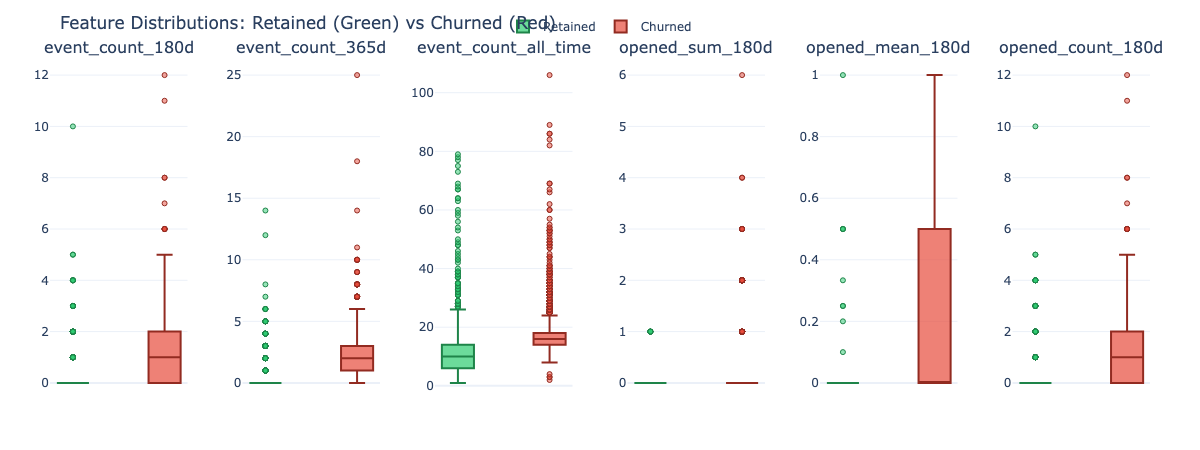


📊 MEAN COMPARISON BY RETENTION STATUS:
----------------------------------------------------------------------
  event_count_180d:
     Retained: 0.10  |  Churned: 1.10  |  Diff: -90.8%
  event_count_365d:
     Retained: 0.26  |  Churned: 2.26  |  Diff: -88.3%
  event_count_all_time:
     Retained: 11.27  |  Churned: 17.25  |  Diff: -34.6%
  opened_sum_180d:
     Retained: 0.00  |  Churned: 0.26  |  Diff: -98.2%
  opened_mean_180d:
     Retained: 0.03  |  Churned: 0.23  |  Diff: -85.5%
  opened_count_180d:
     Retained: 0.10  |  Churned: 1.10  |  Diff: -90.8%


In [6]:
# Box Plots: Visual comparison of distributions
if findings.target_column and findings.target_column in df.columns:
    target = findings.target_column
    
    feature_cols = [
        name for name, col in findings.columns.items()
        if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
        and name != target
        and name not in TEMPORAL_METADATA_COLS
    ]
    
    if feature_cols:
        # Create box plots - one subplot per feature for better control
        n_features = min(len(feature_cols), 6)
        
        fig = make_subplots(
            rows=1, cols=n_features,
            subplot_titles=feature_cols[:n_features],
            horizontal_spacing=0.05
        )
        
        for i, col in enumerate(feature_cols[:n_features]):
            col_num = i + 1
            
            # Retained (1) - Green
            retained_data = df[df[target] == 1][col].dropna()
            fig.add_trace(
                go.Box(
                    y=retained_data,
                    name='Retained',
                    fillcolor='rgba(46, 204, 113, 0.7)',
                    line=dict(color='#1e8449', width=2),
                    marker=dict(
                        color='rgba(46, 204, 113, 0.5)',  # Light green outliers
                        size=5,
                        line=dict(color='#1e8449', width=1)
                    ),
                    boxpoints='outliers',
                    width=0.35,
                    showlegend=(i == 0),
                    legendgroup='retained',
                    offsetgroup='retained'
                ),
                row=1, col=col_num
            )
            
            # Churned (0) - Red
            churned_data = df[df[target] == 0][col].dropna()
            fig.add_trace(
                go.Box(
                    y=churned_data,
                    name='Churned',
                    fillcolor='rgba(231, 76, 60, 0.7)',
                    line=dict(color='#922b21', width=2),
                    marker=dict(
                        color='rgba(231, 76, 60, 0.5)',  # Light red outliers
                        size=5,
                        line=dict(color='#922b21', width=1)
                    ),
                    boxpoints='outliers',
                    width=0.35,
                    showlegend=(i == 0),
                    legendgroup='churned',
                    offsetgroup='churned'
                ),
                row=1, col=col_num
            )
        
        fig.update_layout(
            height=450,
            title_text="Feature Distributions: Retained (Green) vs Churned (Red)",
            template='plotly_white',
            showlegend=True,
            legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="center", x=0.5),
            boxmode='group',
            boxgap=0.3,
            boxgroupgap=0.1
        )
        
        # Center the boxes by removing x-axis tick labels (title is above each subplot)
        fig.update_xaxes(showticklabels=False)
        
        display_figure(fig)
        
        # Print mean comparison
        print("\n📊 MEAN COMPARISON BY RETENTION STATUS:")
        print("-" * 70)
        for col in feature_cols[:n_features]:
            retained_mean = df[df[target] == 1][col].mean()
            churned_mean = df[df[target] == 0][col].mean()
            diff_pct = ((retained_mean - churned_mean) / churned_mean * 100) if churned_mean != 0 else 0
            print(f"  {col}:")
            print(f"     Retained: {retained_mean:.2f}  |  Churned: {churned_mean:.2f}  |  Diff: {diff_pct:+.1f}%")

## 4.5 Feature-Target Correlations

Features ranked by absolute correlation with the target variable.

**📖 Interpretation:**
- **Positive correlation**: Higher values = more likely retained
- **Negative correlation**: Higher values = more likely churned
- **|r| > 0.3**: Moderately predictive
- **|r| > 0.5**: Strongly predictive

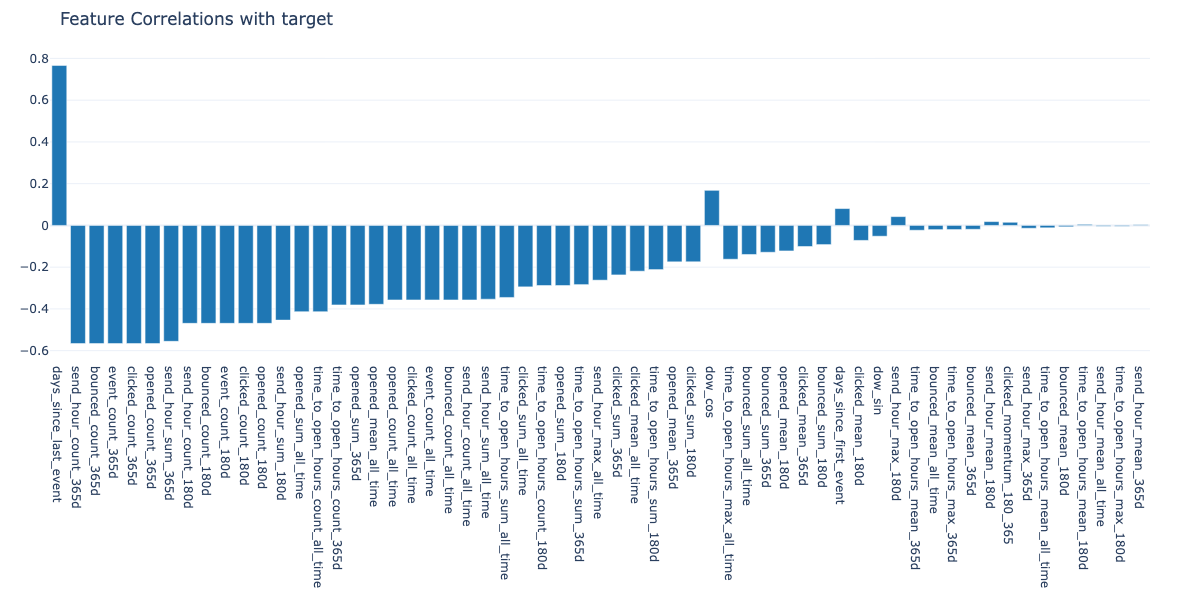

In [7]:
if findings.target_column and findings.target_column in df.columns:
    target = findings.target_column
    feature_cols = [
        name for name, col in findings.columns.items()
        if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
        and name != target
        and name not in TEMPORAL_METADATA_COLS
    ]
    
    if feature_cols:
        correlations = []
        for col in feature_cols:
            corr = df[[col, target]].corr().iloc[0, 1]
            correlations.append({"Feature": col, "Correlation": corr})
        
        corr_df = pd.DataFrame(correlations).sort_values("Correlation", key=abs, ascending=False)
        
        fig = charts.bar_chart(
            corr_df["Feature"].tolist(),
            corr_df["Correlation"].tolist(),
            title=f"Feature Correlations with {target}"
        )
        display_figure(fig)
else:
    print("Target column not available for correlation analysis.")

## 4.6 Categorical Feature Analysis

Retention rates by category help identify which segments are at higher risk.

**📖 What to Look For:**
- Categories with **low retention rates** = high-risk segments for intervention
- **Large variation** across categories = strong predictive feature
- **Small categories** with extreme rates may be unreliable (small sample size)

**📊 Metrics Explained:**
- **Retention Rate**: % of customers in category who were retained
- **Lift**: How much better/worse than overall retention rate (>1 = better, <1 = worse)
- **Cramér's V**: Strength of association (0-1 scale, like correlation for categorical)

CATEGORICAL FEATURE ANALYSIS
Overall retention rate: 39.3%

📈 Categorical Feature Strength (Cramér's V):
------------------------------------------------------------
  🔴 lifecycle_quadrant: V=0.665 (Strong) ***
  🔴 recency_bucket: V=0.598 (Strong) ***

📊 LIFECYCLE_QUADRANT


,lifecycle_quadrant,Count,Retention Rate,Lift,% of Data
0,Intense & Brief,1627,77.7%,1.98x,32.6%
1,One-shot,867,59.1%,1.50x,17.3%
2,Occasional & Loyal,1632,7.8%,0.20x,32.7%
3,Steady & Loyal,872,6.9%,0.18x,17.4%


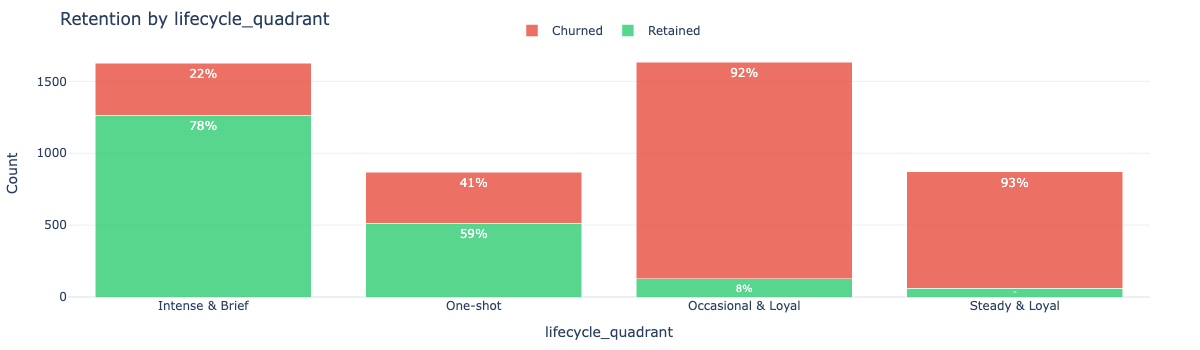


  ⚠️ High-risk categories (lift < 0.9x):
     • Occasional & Loyal: 7.8% retention (0.20x lift)
     • Steady & Loyal: 6.9% retention (0.18x lift)

📊 RECENCY_BUCKET


,recency_bucket,Count,Retention Rate,Lift,% of Data
0,>180d,2884,64.3%,1.64x,57.7%
1,91-180d,804,6.3%,0.16x,16.1%
2,31-90d,818,5.3%,0.13x,16.4%
3,8-30d,358,3.4%,0.09x,7.2%
4,0-7d,134,3.0%,0.08x,2.7%


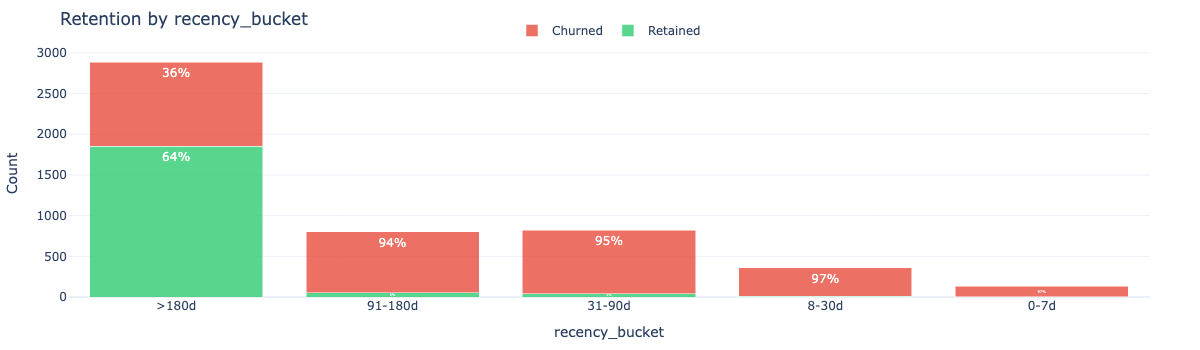


  ⚠️ High-risk categories (lift < 0.9x):
     • 91-180d: 6.3% retention (0.16x lift)
     • 31-90d: 5.3% retention (0.13x lift)
     • 8-30d: 3.4% retention (0.09x lift)
     • 0-7d: 3.0% retention (0.08x lift)


In [8]:
from customer_retention.stages.profiling import CategoricalTargetAnalyzer

if findings.target_column:
    target = findings.target_column
    overall_retention = df[target].mean()
    
    categorical_cols = [
        name for name, col in findings.columns.items()
        if col.inferred_type in [ColumnType.CATEGORICAL_NOMINAL, ColumnType.CATEGORICAL_ORDINAL]
        and name not in TEMPORAL_METADATA_COLS
    ]
    
    print("=" * 80)
    print("CATEGORICAL FEATURE ANALYSIS")
    print("=" * 80)
    print(f"Overall retention rate: {overall_retention:.1%}")
    
    if categorical_cols:
        # Use framework analyzer for summary
        cat_analyzer = CategoricalTargetAnalyzer(min_samples_per_category=10)
        summary_df = cat_analyzer.analyze_multiple(df, categorical_cols, target)
        
        print("\n📈 Categorical Feature Strength (Cramér's V):")
        print("-" * 60)
        for _, row in summary_df.iterrows():
            if row["cramers_v"] >= 0.3:
                strength = "Strong"
                emoji = "🔴"
            elif row["cramers_v"] >= 0.1:
                strength = "Moderate"
                emoji = "🟡"
            else:
                strength = "Weak"
                emoji = "🟢"
            sig = "***" if row["p_value"] < 0.001 else "**" if row["p_value"] < 0.01 else "*" if row["p_value"] < 0.05 else ""
            print(f"  {emoji} {row['feature']}: V={row['cramers_v']:.3f} ({strength}) {sig}")
        
        # Detailed analysis for each categorical feature
        for col_name in categorical_cols[:5]:
            result = cat_analyzer.analyze(df, col_name, target)
            
            print(f"\n{'='*60}")
            print(f"📊 {col_name.upper()}")
            print("="*60)
            
            # Display stats table
            if len(result.category_stats) > 0:
                display_stats = result.category_stats[['category', 'total_count', 'retention_rate', 'lift', 'pct_of_total']].copy()
                display_stats['retention_rate'] = display_stats['retention_rate'].apply(lambda x: f"{x:.1%}")
                display_stats['lift'] = display_stats['lift'].apply(lambda x: f"{x:.2f}x")
                display_stats['pct_of_total'] = display_stats['pct_of_total'].apply(lambda x: f"{x:.1%}")
                display_stats.columns = [col_name, 'Count', 'Retention Rate', 'Lift', '% of Data']
                display(display_stats)
                
                # Stacked bar chart
                cat_stats = result.category_stats
                categories = cat_stats['category'].tolist()
                retained_counts = cat_stats['retained_count'].tolist()
                churned_counts = cat_stats['churned_count'].tolist()
                
                fig = go.Figure()
                
                fig.add_trace(go.Bar(
                    name='Retained',
                    x=categories,
                    y=retained_counts,
                    marker_color='rgba(46, 204, 113, 0.8)',
                    text=[f"{r/(r+c)*100:.0f}%" for r, c in zip(retained_counts, churned_counts)],
                    textposition='inside',
                    textfont=dict(color='white', size=12)
                ))
                
                fig.add_trace(go.Bar(
                    name='Churned',
                    x=categories,
                    y=churned_counts,
                    marker_color='rgba(231, 76, 60, 0.8)',
                    text=[f"{c/(r+c)*100:.0f}%" for r, c in zip(retained_counts, churned_counts)],
                    textposition='inside',
                    textfont=dict(color='white', size=12)
                ))
                
                fig.update_layout(
                    barmode='stack',
                    title=f"Retention by {col_name}",
                    xaxis_title=col_name,
                    yaxis_title="Count",
                    template='plotly_white',
                    height=350,
                    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
                )
                display_figure(fig)
                
                # Flag high-risk categories from framework result
                if result.high_risk_categories:
                    print(f"\n  ⚠️ High-risk categories (lift < 0.9x):")
                    for cat in result.high_risk_categories:
                        cat_row = cat_stats[cat_stats['category'] == cat].iloc[0]
                        print(f"     • {cat}: {cat_row['retention_rate']:.1%} retention ({cat_row['lift']:.2f}x lift)")
    else:
        print("\n  ℹ️ No categorical columns detected.")
else:
    print("No target column available for categorical analysis.")

## 4.7 Scatter Plot Matrix (Sample)

Visual exploration of pairwise relationships between numeric features.

**📖 How to Read the Scatter Matrix:**
- **Diagonal**: Distribution of each feature (histogram or density)
- **Off-diagonal**: Scatter plot showing relationship between two features
- Each row/column represents one feature

**🔍 What to Look For:**

| Pattern | What It Means | Action |
|---------|--------------|--------|
| **Linear trend** (diagonal line of points) | Strong correlation | Check if redundant; may cause multicollinearity |
| **Curved pattern** | Non-linear relationship | Consider polynomial features or transformations |
| **Clusters/groups** | Natural segments in data | May benefit from segment-aware modeling |
| **Fan shape** (spreading out) | Heteroscedasticity | May need log transform or robust methods |
| **Random scatter** | No relationship | Features are independent |

**⚠️ Cautions:**
- Sample shown (max 1000 points) for performance - patterns may differ in full data
- Look for the same patterns in correlation matrix (section 4.2) to confirm

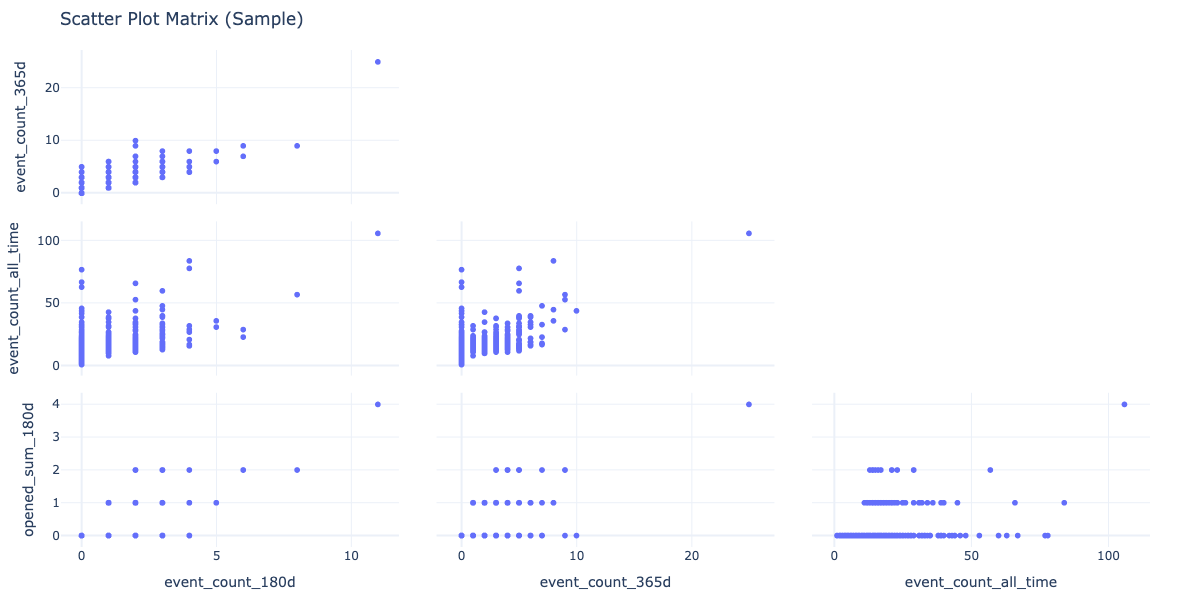

In [9]:
top_numeric = numeric_cols[:4] if len(numeric_cols) > 4 else numeric_cols

if len(top_numeric) >= 2:
    fig = charts.scatter_matrix(
        df[top_numeric].sample(min(1000, len(df))),
        title="Scatter Plot Matrix (Sample)"
    )
    display_figure(fig)

### Interpreting the Scatter Matrix Above

**🎯 Key Questions to Answer:**

1. **Are any features redundant?**
   - Look for tight linear patterns → high correlation → consider dropping one
   - Cross-reference with high correlation pairs in section 4.3

2. **Are there natural customer segments?**
   - Distinct clusters suggest different customer types
   - Links to segment-aware outlier analysis in notebook 03

3. **Do relationships suggest feature engineering?**
   - Curved patterns → polynomial or interaction terms may help
   - Ratios between correlated features may be more predictive

4. **Are distributions suitable for linear models?**
   - Fan shapes or heavy skew → consider transformations
   - Outlier clusters → verify with segment analysis

**💡 Pro Tip:** Hover over points in the interactive plot to see exact values. Look for outliers that appear across multiple scatter plots - these may be influential observations worth investigating.

## 4.8 Datetime Feature Analysis

Temporal patterns can reveal important retention signals - when customers joined, their last activity, and seasonal patterns.

**📖 What to Look For:**
- **Cohort effects**: Do customers who joined in certain periods have different retention?
- **Recency patterns**: How does time since last activity relate to retention?
- **Seasonal trends**: Are there monthly or quarterly patterns?

**📊 Common Temporal Features:**
| Feature Type | Example | Typical Insight |
|-------------|---------|-----------------|
| **Tenure** | Days since signup | Longer tenure often = higher retention |
| **Recency** | Days since last order | Recent activity = engaged customer |
| **Cohort** | Signup month/year | Economic conditions affect cohorts |
| **Day of Week** | Signup day | Weekend vs weekday patterns |

In [10]:
from customer_retention.stages.profiling import TemporalTargetAnalyzer

datetime_cols = [
    name for name, col in findings.columns.items()
    if col.inferred_type == ColumnType.DATETIME
]

print("=" * 80)
print("DATETIME FEATURE ANALYSIS")
print("=" * 80)
print(f"Detected datetime columns: {datetime_cols}")

if datetime_cols and findings.target_column:
    target = findings.target_column
    overall_retention = df[target].mean()
    
    # Use framework analyzer
    temporal_analyzer = TemporalTargetAnalyzer(min_samples_per_period=10)
    
    for col_name in datetime_cols[:3]:
        result = temporal_analyzer.analyze(df, col_name, target)
        
        print(f"\n{'='*60}")
        print(f"📅 {col_name.upper()}")
        print("="*60)
        
        if result.n_valid_dates == 0:
            print("  No valid dates found")
            continue
        
        print(f"  Date range: {result.min_date} to {result.max_date}")
        print(f"  Valid dates: {result.n_valid_dates:,}")
        
        # 1. Retention by Year (from framework result)
        if len(result.yearly_stats) > 1:
            print(f"\n  📊 Retention by Year: Trend is {result.yearly_trend}")
            
            year_stats = result.yearly_stats
            
            fig = make_subplots(rows=1, cols=2, subplot_titles=["Retention Rate by Year", "Customer Count by Year"],
                               column_widths=[0.6, 0.4])
            
            fig.add_trace(
                go.Scatter(
                    x=year_stats['period'].astype(str),
                    y=year_stats['retention_rate'],
                    mode='lines+markers',
                    name='Retention Rate',
                    line=dict(color='#3498db', width=3),
                    marker=dict(size=10)
                ),
                row=1, col=1
            )
            fig.add_hline(y=overall_retention, line_dash="dash", line_color="gray",
                         annotation_text=f"Overall: {overall_retention:.1%}", row=1, col=1)
            
            fig.add_trace(
                go.Bar(
                    x=year_stats['period'].astype(str),
                    y=year_stats['count'],
                    name='Count',
                    marker_color='rgba(52, 152, 219, 0.6)'
                ),
                row=1, col=2
            )
            
            fig.update_layout(height=350, template='plotly_white', showlegend=False)
            fig.update_yaxes(tickformat='.0%', row=1, col=1)
            display_figure(fig)
        
        # 2. Retention by Month (from framework result)
        if len(result.monthly_stats) > 1:
            print(f"\n  📊 Retention by Month (Seasonality):")
            
            month_stats = result.monthly_stats
            colors = ['rgba(46, 204, 113, 0.7)' if r >= overall_retention else 'rgba(231, 76, 60, 0.7)' 
                     for r in month_stats['retention_rate']]
            
            fig = go.Figure()
            fig.add_trace(go.Bar(
                x=month_stats['month_name'],
                y=month_stats['retention_rate'],
                marker_color=colors,
                text=[f"{r:.0%}" for r in month_stats['retention_rate']],
                textposition='outside'
            ))
            fig.add_hline(y=overall_retention, line_dash="dash", line_color="gray",
                         annotation_text=f"Overall: {overall_retention:.1%}")
            
            fig.update_layout(
                title=f"Monthly Retention Pattern ({col_name})",
                xaxis_title="Month",
                yaxis_title="Retention Rate",
                template='plotly_white',
                height=350,
                yaxis_tickformat='.0%'
            )
            display_figure(fig)
            
            # Seasonal insights from framework
            if result.seasonal_spread > 0.05:
                print(f"  📈 Seasonal spread: {result.seasonal_spread:.1%}")
                print(f"     Best month: {result.best_month}")
                print(f"     Worst month: {result.worst_month}")
        
        # 3. Retention by Day of Week (from framework result)
        if len(result.dow_stats) > 1:
            print(f"\n  📊 Retention by Day of Week:")
            
            dow_stats = result.dow_stats
            colors = ['rgba(46, 204, 113, 0.7)' if r >= overall_retention else 'rgba(231, 76, 60, 0.7)' 
                     for r in dow_stats['retention_rate']]
            
            fig = go.Figure()
            fig.add_trace(go.Bar(
                x=dow_stats['day_name'],
                y=dow_stats['retention_rate'],
                marker_color=colors,
                text=[f"{r:.0%}" for r in dow_stats['retention_rate']],
                textposition='outside'
            ))
            fig.add_hline(y=overall_retention, line_dash="dash", line_color="gray")
            
            fig.update_layout(
                title=f"Day of Week Pattern ({col_name})",
                xaxis_title="Day of Week",
                yaxis_title="Retention Rate",
                template='plotly_white',
                height=300,
                yaxis_tickformat='.0%'
            )
            display_figure(fig)
else:
    if not datetime_cols:
        print("\n  ℹ️ No datetime columns detected in this dataset.")
        print("     Consider adding date parsing in notebook 01 if dates exist as strings.")
    else:
        print("\n  ℹ️ No target column available for retention analysis.")

DATETIME FEATURE ANALYSIS
Detected datetime columns: []

  ℹ️ No datetime columns detected in this dataset.
     Consider adding date parsing in notebook 01 if dates exist as strings.


## 4.9 Actionable Recommendations Summary

This section consolidates all relationship analysis findings into **actionable recommendations** organized by their impact on the modeling pipeline.

**📋 Recommendation Categories:**

| Category | Purpose | Impact |
|----------|---------|--------|
| **Feature Selection** | Which features to keep/drop | Reduces noise, improves interpretability |
| **Feature Engineering** | New features to create | Captures interactions, improves accuracy |
| **Stratification** | Train/test split strategy | Ensures fair evaluation, prevents leakage |
| **Model Selection** | Which algorithms to try | Matches model to data characteristics |

In [11]:
# Generate comprehensive actionable recommendations
recommender = RelationshipRecommender()

# Gather columns by type
numeric_features = [
    name for name, col in findings.columns.items()
    if col.inferred_type in [ColumnType.NUMERIC_CONTINUOUS, ColumnType.NUMERIC_DISCRETE]
    and name != findings.target_column
    and name not in TEMPORAL_METADATA_COLS
]
categorical_features = [
    name for name, col in findings.columns.items()
    if col.inferred_type in [ColumnType.CATEGORICAL_NOMINAL, ColumnType.CATEGORICAL_ORDINAL]
    and name not in TEMPORAL_METADATA_COLS
]

# Run comprehensive analysis
analysis_summary = recommender.analyze(
    df,
    numeric_cols=numeric_features,
    categorical_cols=categorical_features,
    target_col=findings.target_column,
)

print("=" * 80)
print("ACTIONABLE RECOMMENDATIONS FROM RELATIONSHIP ANALYSIS")
print("=" * 80)

# Group recommendations by category
grouped_recs = analysis_summary.recommendations_by_category
high_priority = analysis_summary.high_priority_actions

if high_priority:
    print(f"\n🔴 HIGH PRIORITY ACTIONS ({len(high_priority)}):")
    print("-" * 60)
    for rec in high_priority:
        print(f"\n  📌 {rec.title}")
        print(f"     {rec.description}")
        print(f"     → Action: {rec.action}")
        if rec.affected_features:
            print(f"     → Features: {', '.join(rec.affected_features[:5])}")

# Persist recommendations to registry
for pair in analysis_summary.multicollinear_pairs:
    registry.add_gold_drop_multicollinear(
        column=pair["feature1"], correlated_with=pair["feature2"],
        correlation=pair["correlation"],
        rationale=f"High correlation ({pair['correlation']:.2f}) - consider dropping one",
        source_notebook="04_relationship_analysis"
    )

for predictor in analysis_summary.strong_predictors:
    registry.add_gold_prioritize_feature(
        column=predictor["feature"], effect_size=predictor["effect_size"],
        correlation=predictor["correlation"],
        rationale=f"Strong predictor with effect size {predictor['effect_size']:.2f}",
        source_notebook="04_relationship_analysis"
    )

for weak_col in analysis_summary.weak_predictors[:10]:
    registry.add_gold_drop_weak(
        column=weak_col, effect_size=0.0, correlation=0.0,
        rationale="Negligible predictive power",
        source_notebook="04_relationship_analysis"
    )

# Persist ratio feature recommendations
for rec in grouped_recs.get(RecommendationCategory.FEATURE_ENGINEERING, []):
    if "ratio" in rec.title.lower() and len(rec.affected_features) >= 2:
        registry.add_silver_ratio(
            column=f"{rec.affected_features[0]}_to_{rec.affected_features[1]}_ratio",
            numerator=rec.affected_features[0], denominator=rec.affected_features[1],
            rationale=rec.description, source_notebook="04_relationship_analysis"
        )
    elif "interaction" in rec.title.lower() and len(rec.affected_features) >= 2:
        for i, f1 in enumerate(rec.affected_features[:3]):
            for f2 in rec.affected_features[i+1:4]:
                registry.add_silver_interaction(
                    column=f"{f1}_x_{f2}", features=[f1, f2],
                    rationale=rec.description, source_notebook="04_relationship_analysis"
                )

# Store for findings metadata
findings.metadata["relationship_analysis"] = {
    "n_recommendations": len(analysis_summary.recommendations),
    "n_high_priority": len(high_priority),
    "strong_predictors": [p["feature"] for p in analysis_summary.strong_predictors],
    "weak_predictors": analysis_summary.weak_predictors[:5],
    "multicollinear_pairs": [(p["feature1"], p["feature2"]) for p in analysis_summary.multicollinear_pairs],
}

print(f"\n✅ Persisted {len(analysis_summary.multicollinear_pairs)} multicollinearity recommendations")
print(f"✅ Persisted {len(analysis_summary.strong_predictors)} strong predictor recommendations")
print(f"✅ Persisted {min(len(analysis_summary.weak_predictors), 10)} weak predictor recommendations")

ACTIONABLE RECOMMENDATIONS FROM RELATIONSHIP ANALYSIS

🔴 HIGH PRIORITY ACTIONS (64):
------------------------------------------------------------

  📌 Remove multicollinear feature
     event_count_180d and opened_count_180d are highly correlated (r=1.00)
     → Action: Consider dropping one of these features. Keep the one with stronger business meaning or higher target correlation.
     → Features: event_count_180d, opened_count_180d

  📌 Remove multicollinear feature
     event_count_180d and clicked_count_180d are highly correlated (r=1.00)
     → Action: Consider dropping one of these features. Keep the one with stronger business meaning or higher target correlation.
     → Features: event_count_180d, clicked_count_180d

  📌 Remove multicollinear feature
     event_count_180d and send_hour_sum_180d are highly correlated (r=0.98)
     → Action: Consider dropping one of these features. Keep the one with stronger business meaning or higher target correlation.
     → Features: event_co

### 4.9.1 Feature Selection Recommendations

**What these recommendations tell you:**
- Which features to **prioritize** (strong predictors)
- Which features to **consider dropping** (weak predictors, redundant features)
- Which feature pairs cause **multicollinearity** issues

**📊 Decision Guide:**

| Finding | Linear Models | Tree-Based Models |
|---------|--------------|-------------------|
| Strong predictors | Include - will have high coefficients | Include - will appear early in splits |
| Weak predictors | Consider dropping | May help in interactions |
| Multicollinear pairs | Drop one feature | Can keep both (trees handle it) |

In [12]:
# Feature Selection Recommendations
selection_recs = grouped_recs.get(RecommendationCategory.FEATURE_SELECTION, [])

print("=" * 70)
print("FEATURE SELECTION")
print("=" * 70)

# Strong predictors summary
if analysis_summary.strong_predictors:
    print("\n✅ STRONG PREDICTORS (prioritize these):")
    strong_df = pd.DataFrame(analysis_summary.strong_predictors)
    strong_df["effect_size"] = strong_df["effect_size"].apply(lambda x: f"{x:+.3f}")
    strong_df["correlation"] = strong_df["correlation"].apply(lambda x: f"{x:+.3f}")
    strong_df = strong_df.sort_values("effect_size", key=lambda x: x.str.replace("+", "").astype(float).abs(), ascending=False)
    display(strong_df)
    
    print("\n   💡 These features show strong discrimination between retained/churned customers.")
    print("   → Ensure they're included in your model")
    print("   → Check for data quality issues that could inflate their importance")

# Weak predictors summary
if analysis_summary.weak_predictors:
    print(f"\n⚪ WEAK PREDICTORS (consider dropping): {', '.join(analysis_summary.weak_predictors[:5])}")
    print("   → Low individual predictive power, but may help in combination")

# Multicollinearity summary
if analysis_summary.multicollinear_pairs:
    print("\n⚠️ MULTICOLLINEAR PAIRS (drop one from each pair for linear models):")
    for pair in analysis_summary.multicollinear_pairs:
        print(f"   • {pair['feature1']} ↔ {pair['feature2']}: r = {pair['correlation']:.2f}")
    print("\n   💡 For each pair, keep the feature with:")
    print("      - Stronger business meaning")
    print("      - Higher target correlation")
    print("      - Fewer missing values")

# Display all feature selection recommendations
if selection_recs:
    print("\n" + "-" * 70)
    print("DETAILED RECOMMENDATIONS:")
    for rec in selection_recs:
        priority_icon = "🔴" if rec.priority == "high" else "🟡" if rec.priority == "medium" else "🟢"
        print(f"\n{priority_icon} {rec.title}")
        print(f"   {rec.description}")
        print(f"   → {rec.action}")

FEATURE SELECTION

✅ STRONG PREDICTORS (prioritize these):


,feature,correlation,effect_size
31,days_since_last_event,+0.766,+2.442
13,opened_count_365d,-0.566,-1.405
17,bounced_count_365d,-0.566,-1.405
1,event_count_365d,-0.566,-1.405
14,clicked_count_365d,-0.566,-1.405
16,send_hour_count_365d,-0.566,-1.405
15,send_hour_sum_365d,-0.555,-1.367
6,clicked_count_180d,-0.469,-1.087
5,opened_count_180d,-0.469,-1.087
0,event_count_180d,-0.469,-1.087



   💡 These features show strong discrimination between retained/churned customers.
   → Ensure they're included in your model
   → Check for data quality issues that could inflate their importance

⚪ WEAK PREDICTORS (consider dropping): send_hour_mean_180d, send_hour_max_180d, bounced_sum_180d, bounced_mean_180d, time_to_open_hours_mean_180d
   → Low individual predictive power, but may help in combination

⚠️ MULTICOLLINEAR PAIRS (drop one from each pair for linear models):
   • event_count_180d ↔ event_count_365d: r = 0.81
   • event_count_180d ↔ opened_count_180d: r = 1.00
   • event_count_180d ↔ clicked_count_180d: r = 1.00
   • event_count_180d ↔ send_hour_sum_180d: r = 0.98
   • event_count_180d ↔ send_hour_count_180d: r = 1.00
   • event_count_180d ↔ bounced_count_180d: r = 1.00
   • event_count_180d ↔ opened_count_365d: r = 0.81
   • event_count_180d ↔ clicked_count_365d: r = 0.81
   • event_count_180d ↔ send_hour_sum_365d: r = 0.79
   • event_count_180d ↔ send_hour_count_365d

### 4.9.2 Stratification Recommendations

**What these recommendations tell you:**
- How to **split your data** for training and testing
- Which **segments require special attention** in sampling
- **High-risk segments** that need adequate representation

**⚠️ Why This Matters:**
- Random splits can under-represent rare segments
- High-risk segments may be systematically excluded
- Model evaluation will be biased without proper stratification

**📊 Implementation:**
```python
from sklearn.model_selection import train_test_split

# Stratified split by target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Multi-column stratification (for categorical segments)
df['stratify_col'] = df['target'].astype(str) + '_' + df['segment']
```

In [13]:
# Stratification Recommendations
strat_recs = grouped_recs.get(RecommendationCategory.STRATIFICATION, [])

print("=" * 70)
print("STRATIFICATION (Train/Test Split Strategy)")
print("=" * 70)

# High-risk segments
if analysis_summary.high_risk_segments:
    print("\n🎯 HIGH-RISK SEGMENTS (ensure representation in training data):")
    risk_df = pd.DataFrame(analysis_summary.high_risk_segments)
    risk_df["retention_rate"] = risk_df["retention_rate"].apply(lambda x: f"{x:.1%}")
    risk_df["lift"] = risk_df["lift"].apply(lambda x: f"{x:.2f}x")
    display(risk_df[["feature", "segment", "count", "retention_rate", "lift"]])
    
    print("\n   💡 These segments have below-average retention.")
    print("   → Ensure they're adequately represented in both train and test sets")
    print("   → Consider oversampling or class weights in modeling")

# Display all stratification recommendations
if strat_recs:
    print("\n" + "-" * 70)
    print("STRATIFICATION RECOMMENDATIONS:")
    for rec in strat_recs:
        priority_icon = "🔴" if rec.priority == "high" else "🟡" if rec.priority == "medium" else "🟢"
        print(f"\n{priority_icon} {rec.title}")
        print(f"   {rec.description}")
        print(f"   → {rec.action}")
else:
    print("\n✅ No special stratification requirements detected.")
    print("   Standard stratified split by target variable is sufficient.")

STRATIFICATION (Train/Test Split Strategy)

🎯 HIGH-RISK SEGMENTS (ensure representation in training data):


,feature,segment,count,retention_rate,lift
0,lifecycle_quadrant,Occasional & Loyal,1632,7.8%,0.20x
1,lifecycle_quadrant,Steady & Loyal,872,6.9%,0.18x
2,recency_bucket,0-7d,134,3.0%,0.08x
3,recency_bucket,31-90d,818,5.3%,0.13x
4,recency_bucket,8-30d,358,3.4%,0.09x
5,recency_bucket,91-180d,804,6.3%,0.16x



   💡 These segments have below-average retention.
   → Ensure they're adequately represented in both train and test sets
   → Consider oversampling or class weights in modeling

----------------------------------------------------------------------
STRATIFICATION RECOMMENDATIONS:

🔴 Stratify by lifecycle_quadrant
   Significant variation in retention rates across lifecycle_quadrant categories (spread: 70.8%)
   → Use stratified sampling by lifecycle_quadrant in train/test split to ensure all segments are represented.

🔴 Stratify by recency_bucket
   Significant variation in retention rates across recency_bucket categories (spread: 61.3%)
   → Use stratified sampling by recency_bucket in train/test split to ensure all segments are represented.

🔴 Monitor high-risk segments
   Segments with below-average retention: 0-7d, Steady & Loyal, Occasional & Loyal
   → Target these segments for intervention campaigns and ensure adequate representation in training data.


### 4.9.3 Model Selection Recommendations

**What these recommendations tell you:**
- Which **model types** are well-suited for your data characteristics
- **Linear vs non-linear** based on relationship patterns
- **Ensemble considerations** based on feature interactions

**📊 Model Selection Guide Based on Data Characteristics:**

| Data Characteristic | Recommended Models | Reason |
|---------------------|-------------------|--------|
| Strong linear relationships | Logistic Regression, Linear SVM | Interpretable, fast, less overfit risk |
| Non-linear patterns | Random Forest, XGBoost, LightGBM | Capture complex interactions |
| High multicollinearity | Tree-based models | Robust to correlated features |
| Many categorical features | CatBoost, LightGBM | Native categorical handling |
| Imbalanced classes | Any with class_weight='balanced' | Adjust for minority class |

In [14]:
# Model Selection Recommendations
model_recs = grouped_recs.get(RecommendationCategory.MODEL_SELECTION, [])

print("=" * 70)
print("MODEL SELECTION")
print("=" * 70)

if model_recs:
    for rec in model_recs:
        priority_icon = "🔴" if rec.priority == "high" else "🟡" if rec.priority == "medium" else "🟢"
        print(f"\n{priority_icon} {rec.title}")
        print(f"   {rec.description}")
        print(f"   → {rec.action}")

# Summary recommendations based on data characteristics
print("\n" + "-" * 70)
print("RECOMMENDED MODELING APPROACH:")

has_multicollinearity = len(analysis_summary.multicollinear_pairs) > 0
has_strong_linear = len([p for p in analysis_summary.strong_predictors if abs(p.get("effect_size", 0)) >= 0.5]) > 0
has_categoricals = len(categorical_features) > 0

if has_strong_linear and not has_multicollinearity:
    print("\n✅ RECOMMENDED: Start with Logistic Regression")
    print("   • Strong linear relationships detected")
    print("   • Interpretable coefficients for business insights")
    print("   • Fast training and inference")
    print("   • Then compare with tree-based ensemble for potential improvement")
elif has_multicollinearity:
    print("\n✅ RECOMMENDED: Start with Random Forest or XGBoost")
    print("   • Multicollinearity present - tree models handle it naturally")
    print("   • Can keep all features without VIF analysis")
    print("   • Use feature importance to understand contributions")
else:
    print("\n✅ RECOMMENDED: Compare Linear and Tree-Based Models")
    print("   • No clear linear dominance - test both approaches")
    print("   • Logistic Regression for interpretability baseline")
    print("   • Random Forest/XGBoost for potential accuracy gain")

if has_categoricals:
    print("\n💡 CATEGORICAL HANDLING:")
    print("   • For tree models: Consider CatBoost or LightGBM with native categorical support")
    print("   • For linear models: Use target encoding for high-cardinality features")

MODEL SELECTION

🟡 Consider tree-based models for multicollinearity
   Found 146 highly correlated feature pairs
   → Tree-based models (Random Forest, XGBoost) are robust to multicollinearity. For linear models, remove redundant features first.

🟡 Linear models may perform well
   Strong linear relationships detected (avg effect size: 0.98)
   → Start with Logistic Regression as baseline. Clear feature-target relationships suggest interpretable models may work well.

🟡 Categorical features are predictive
   Strong categorical associations: lifecycle_quadrant, recency_bucket
   → Use target encoding for tree-based models or one-hot encoding for linear models. Consider CatBoost for native categorical handling.

----------------------------------------------------------------------
RECOMMENDED MODELING APPROACH:

✅ RECOMMENDED: Start with Random Forest or XGBoost
   • Multicollinearity present - tree models handle it naturally
   • Can keep all features without VIF analysis
   • Use feat

### 4.9.4 Feature Engineering Recommendations

**What these recommendations tell you:**
- **Interaction features** to create based on correlation patterns
- **Ratio features** that may capture relative relationships
- **Polynomial features** for non-linear patterns

**📊 Common Feature Engineering Patterns:**

| Pattern Found | Feature to Create | Example |
|---------------|------------------|---------|
| Moderate correlation | Ratio feature | `feature_a / feature_b` |
| Both features predictive | Interaction term | `feature_a * feature_b` |
| Curved scatter pattern | Polynomial | `feature_a ** 2` |
| Related semantics | Difference | `total_orders - returned_orders` |

In [15]:
# Feature Engineering Recommendations
eng_recs = grouped_recs.get(RecommendationCategory.FEATURE_ENGINEERING, [])

print("=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

if eng_recs:
    for rec in eng_recs:
        priority_icon = "🔴" if rec.priority == "high" else "🟡" if rec.priority == "medium" else "🟢"
        print(f"\n{priority_icon} {rec.title}")
        print(f"   {rec.description}")
        print(f"   → {rec.action}")
        if rec.affected_features:
            print(f"   → Features: {', '.join(rec.affected_features[:5])}")
else:
    print("\n✅ No specific feature engineering recommendations based on correlation patterns.")
    print("   Consider domain-specific features based on business knowledge.")

# Additional suggestions based on strong predictors
if analysis_summary.strong_predictors:
    print("\n" + "-" * 70)
    print("POTENTIAL INTERACTION FEATURES:")
    strong_features = [p["feature"] for p in analysis_summary.strong_predictors[:5]]
    if len(strong_features) >= 2:
        print(f"\n   Based on strong predictors, consider interactions between:")
        for i, f1 in enumerate(strong_features[:3]):
            for f2 in strong_features[i+1:4]:
                print(f"   • {f1} × {f2}")
        print("\n   💡 Tree-based models discover interactions automatically.")
        print("   → For linear models, create explicit interaction columns.")

FEATURE ENGINEERING

🟢 Consider ratio features
   Moderately correlated pairs may benefit from ratio features: event_count_180d/event_count_all_time, event_count_180d/opened_sum_180d, event_count_180d/clicked_sum_180d
   → Create ratio features (e.g., feature_a / feature_b) to capture relative relationships.
   → Features: event_count_180d, event_count_180d, event_count_180d, event_count_all_time, opened_sum_180d

🟢 Test feature interactions
   Interaction terms may capture non-linear relationships
   → Use PolynomialFeatures(interaction_only=True) or tree-based models which automatically discover interactions.
   → Features: event_count_180d, event_count_365d, event_count_all_time, opened_sum_180d

----------------------------------------------------------------------
POTENTIAL INTERACTION FEATURES:

   Based on strong predictors, consider interactions between:
   • event_count_180d × event_count_365d
   • event_count_180d × event_count_all_time
   • event_count_180d × opened_sum_180d

### 4.9.5 Recommendations Summary Table

In [16]:
# Create summary table of all recommendations
all_recs_data = []
for rec in analysis_summary.recommendations:
    all_recs_data.append({
        "Category": rec.category.value.replace("_", " ").title(),
        "Priority": rec.priority.upper(),
        "Recommendation": rec.title,
        "Action": rec.action[:80] + "..." if len(rec.action) > 80 else rec.action
    })

if all_recs_data:
    recs_df = pd.DataFrame(all_recs_data)
    
    # Sort by priority
    priority_order = {"HIGH": 0, "MEDIUM": 1, "LOW": 2}
    recs_df["_sort"] = recs_df["Priority"].map(priority_order)
    recs_df = recs_df.sort_values("_sort").drop("_sort", axis=1)
    
    print("=" * 80)
    print("ALL RECOMMENDATIONS SUMMARY")
    print("=" * 80)
    print(f"\nTotal: {len(recs_df)} recommendations")
    print(f"  🔴 High priority: {len(recs_df[recs_df['Priority'] == 'HIGH'])}")
    print(f"  🟡 Medium priority: {len(recs_df[recs_df['Priority'] == 'MEDIUM'])}")
    print(f"  🟢 Low priority: {len(recs_df[recs_df['Priority'] == 'LOW'])}")
    
    display(recs_df)

# Save updated findings and recommendations registry
findings.save(FINDINGS_PATH)
with open(RECOMMENDATIONS_PATH, "w") as f:
    yaml.dump(registry.to_dict(), f, default_flow_style=False, sort_keys=False)

print(f"\n✅ Findings updated with relationship analysis: {FINDINGS_PATH}")
print(f"✅ Recommendations registry saved: {RECOMMENDATIONS_PATH}")
print(f"   Total recommendations in registry: {len(registry.all_recommendations)}")

ALL RECOMMENDATIONS SUMMARY

Total: 156 recommendations
  🔴 High priority: 64
  🟡 Medium priority: 89
  🟢 Low priority: 3


,Category,Priority,Recommendation,Action
47,Feature Selection,HIGH,Remove multicollinear feature,Consider dropping one of these features. Keep ...
114,Feature Selection,HIGH,Remove multicollinear feature,Consider dropping one of these features. Keep ...
35,Feature Selection,HIGH,Remove multicollinear feature,Consider dropping one of these features. Keep ...
36,Feature Selection,HIGH,Remove multicollinear feature,Consider dropping one of these features. Keep ...
37,Feature Selection,HIGH,Remove multicollinear feature,Consider dropping one of these features. Keep ...
...,...,...,...,...
57,Feature Selection,MEDIUM,Remove multicollinear feature,Consider dropping one of these features. Keep ...
71,Feature Selection,MEDIUM,Remove multicollinear feature,Consider dropping one of these features. Keep ...
154,Feature Engineering,LOW,Consider ratio features,"Create ratio features (e.g., feature_a / featu..."
147,Feature Selection,LOW,Consider removing weak predictors,These features may add noise. Consider removin...



✅ Findings updated with relationship analysis: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_findings.yaml
✅ Recommendations registry saved: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_aggregated_846212_recommendations.yaml
   Total recommendations in registry: 299


---

## Summary: What We Learned

In this notebook, we analyzed feature relationships and generated **actionable recommendations** for modeling.

### Analysis Performed

**Numeric Features:**
1. **Correlation Matrix** - Identified multicollinearity issues between feature pairs
2. **Effect Sizes (Cohen's d)** - Quantified how well features discriminate retained vs churned
3. **Box Plots** - Visualized distribution differences between classes
4. **Feature-Target Correlations** - Ranked features by predictive power

**Categorical Features:**
5. **Cramér's V** - Measured association strength for categorical variables
6. **Retention by Category** - Identified high-risk segments
7. **Lift Analysis** - Found categories performing above/below average

**Datetime Features:**
8. **Cohort Analysis** - Retention trends by signup year
9. **Seasonality** - Monthly patterns in retention

### Actionable Recommendations Generated

| Category | What It Tells You | Impact on Pipeline |
|----------|-------------------|-------------------|
| **Feature Selection** | Which features to prioritize/drop | Reduces noise, improves interpretability |
| **Stratification** | How to split train/test | Ensures fair evaluation |
| **Model Selection** | Which algorithms to try first | Matches model to data |
| **Feature Engineering** | Interactions to create | Captures non-linear patterns |

### Key Metrics Reference

| Data Type | Effect Measure | Strong Signal |
|-----------|---------------|---------------|
| Numeric | Cohen's d | \|d\| ≥ 0.8 |
| Numeric | Correlation | \|r\| ≥ 0.5 |
| Categorical | Cramér's V | V ≥ 0.3 |
| Categorical | Lift | < 0.9x or > 1.1x |

---

## Recommended Actions Checklist

Based on the analysis above, here are the key actions to take:

- [ ] **Feature Selection**: Review strong/weak predictors and multicollinear pairs
- [ ] **Stratification**: Use stratified sampling with identified high-risk segments
- [ ] **Model Selection**: Start with recommended model type based on data characteristics
- [ ] **Feature Engineering**: Create interaction features between strong predictors

---

## Next Steps

Continue to **05_feature_opportunities.ipynb** to:
- Generate derived features (tenure, recency, engagement scores)
- Identify interaction features based on relationships found here
- Create business-relevant composite scores
- Review automated feature recommendations